# Importing packages 

In [122]:
# Data wrangling 
import pandas as pd 

# Sklearn elastic net implementation 
from sklearn.linear_model import ElasticNet

# Tensorflow 
import tensorflow as tf

# Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input

# Regularizer
from keras.regularizers import L1L2

# Distance between points calculation 
import haversine as hs

# Ploting 
import matplotlib.pyplot as plt

# Training on cpu 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Array math 
import numpy as np 

# Reading the data 

In [123]:
d = pd.read_csv('data/kc_house_data.csv')

print(f"Shape of data: {d.shape}")
print(f"Features in data: {d.columns.values}")

Shape of data: (21613, 21)
Features in data: ['id' 'date' 'price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot'
 'floors' 'waterfront' 'view' 'condition' 'grade' 'sqft_above'
 'sqft_basement' 'yr_built' 'yr_renovated' 'zipcode' 'lat' 'long'
 'sqft_living15' 'sqft_lot15']


# Feature engineering 

## Distance from city center 

In [124]:
# Defining the Seattle coordinates 
lat_center, long_center = 47.6062, -122.3321

# Calculating the distance from the center of Seattle (in meters)
d['distance_from_center'] = d.apply(lambda x: hs.haversine((x.lat, x.long), (lat_center, long_center)) * 1000, axis=1)

## Flag for renovation event 

In [125]:
d['is_renovated'] = d.apply(lambda x: 1 if x.yr_renovated > 0 else 0, axis=1)

## Age

We will hold that the year 2015 is the last year in the dataset.

In [126]:
# Converting date column to datetime
d['date'] = pd.to_datetime(d['date'])

# Getting the age of the house 
d['age'] = d.apply(lambda x: x.date.year - x.yr_built, axis=1)

## Defining the final feature list 

In [127]:
features = [
    'age',
    'distance_from_center',
    'floors',
    'sqft_living',
    'sqft_lot',
    'sqft_above',
]

y_var = ['price']

d = d[features + y_var].copy()

d.head(10)

,age,distance_from_center,floors,sqft_living,sqft_lot,sqft_above,price
0,59,11972.703646,1.0,1180,5650,1180,221900.0
1,63,12802.836812,2.0,2570,7242,2170,538000.0
2,82,16416.983068,1.0,770,10000,770,180000.0
3,49,10538.247653,1.0,1960,5000,1050,604000.0
4,28,21554.008860,1.0,1680,8080,1680,510000.0
5,13,25131.222621,1.0,5420,101930,3890,1225000.0
6,19,32971.570823,2.0,1715,6819,1715,257500.0
7,52,21909.751716,1.0,1060,9711,1060,291850.0
8,55,10447.689945,1.0,1780,7470,1050,229500.0
9,12,34800.386344,2.0,1890,6560,1890,323000.0


In [128]:
# Standart scaling all the numeric features
for feature in features:
    d[feature] = (d[feature] - d[feature].mean()) / d[feature].std()

# Dropping missing values 
d = d.dropna()

d.head(10)

,age,distance_from_center,floors,sqft_living,sqft_lot,sqft_above,price
0,0.533853,-0.609459,-0.915406,-0.979812,-0.228316,-0.734691,221900.0
1,0.670020,-0.531453,0.936484,0.533622,-0.189881,0.460830,538000.0
2,1.316818,-0.191836,-0.915406,-1.426221,-0.123296,-1.229805,180000.0
3,0.193433,-0.744253,-0.915406,-0.130547,-0.244009,-0.891678,604000.0
4,-0.521449,0.290883,-0.915406,-0.435412,-0.169649,-0.130892,510000.0
5,-1.032079,0.627029,-0.915406,3.636707,2.096136,2.537897,1225000.0
6,-0.827827,1.363775,0.936484,-0.397303,-0.200093,-0.088626,257500.0
7,0.295559,0.324311,-0.915406,-1.110469,-0.130273,-0.879602,291850.0
8,0.397685,-0.752763,-0.915406,-0.326531,-0.184376,-0.891678,229500.0
9,-1.066121,1.535626,0.936484,-0.206763,-0.206346,0.122703,323000.0


# EDA 

In [129]:
d.describe()

,age,distance_from_center,floors,sqft_living,sqft_lot,sqft_above,price
count,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04
mean,1.262427e-16,-2.511704e-16,-4.208091e-17,2.393352e-16,1.315028e-17,1.209826e-16,5.400881e+05
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.671272e+05
min,-1.508666e+00,-1.642135e+00,-9.154058e-01,-1.948846e+00,-3.521677e-01,-1.809452e+00,7.500000e+04
25%,-8.618687e-01,-8.151646e-01,-9.154058e-01,-7.108783e-01,-2.430431e-01,-7.226147e-01,3.219500e+05
50%,-1.129451e-01,-1.831002e-01,1.053914e-02,-1.849871e-01,-1.808034e-01,-2.758039e-01,4.500000e+05
75%,6.700205e-01,6.397055e-01,9.364841e-01,5.118460e-01,-1.066855e-01,5.091340e-01,6.450000e+05
max,2.440204e+00,5.509889e+00,3.714319e+00,1.247778e+01,3.950342e+01,9.203831e+00,7.700000e+06


In [130]:
d.head(10)

,age,distance_from_center,floors,sqft_living,sqft_lot,sqft_above,price
0,0.533853,-0.609459,-0.915406,-0.979812,-0.228316,-0.734691,221900.0
1,0.670020,-0.531453,0.936484,0.533622,-0.189881,0.460830,538000.0
2,1.316818,-0.191836,-0.915406,-1.426221,-0.123296,-1.229805,180000.0
3,0.193433,-0.744253,-0.915406,-0.130547,-0.244009,-0.891678,604000.0
4,-0.521449,0.290883,-0.915406,-0.435412,-0.169649,-0.130892,510000.0
5,-1.032079,0.627029,-0.915406,3.636707,2.096136,2.537897,1225000.0
6,-0.827827,1.363775,0.936484,-0.397303,-0.200093,-0.088626,257500.0
7,0.295559,0.324311,-0.915406,-1.110469,-0.130273,-0.879602,291850.0
8,0.397685,-0.752763,-0.915406,-0.326531,-0.184376,-0.891678,229500.0
9,-1.066121,1.535626,0.936484,-0.206763,-0.206346,0.122703,323000.0


# Elastic net 

We will use $\alpha = 1$ and $\lambda=0.4$. The equation in sklearn is: 

$$ MSE = \dfrac{1}{2} \alpha (1 - \lambda) \sum_{i=1}^p (\beta_i)^{2} + \alpha \lambda \sum_{i=1}^p |\beta_i|+ \frac{1}{2N} ||y - X \beta||^2_2$$

## Scikit learn 

In [131]:
# Defining the params 
alpha = 1.0 
l1_ratio = 0.02

# Fitting the model to data using sklearn
el = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
el.fit(d[features], d[y_var])

# Extracting the coefs 
coefs = el.coef_

# Creating a dataframe with the coefs
coefs_df = pd.DataFrame({'feature': features, 'coef_sk': coefs})

# Appending the intercept
coefs_df = coefs_df.append({'feature': 'intercept', 'coef_sk': el.intercept_[0]}, ignore_index=True)

/tmp/ipykernel_21610/4269339002.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs_df = coefs_df.append({'feature': 'intercept', 'coef_sk': el.intercept_[0]}, ignore_index=True)


In [132]:
coefs_df

,feature,coef_sk
0,age,12999.031247
1,distance_from_center,-62430.341480
2,floors,14022.123588
3,sqft_living,99113.890140
4,sqft_lot,9282.895480
5,sqft_above,72578.847965
6,intercept,540088.141767


## Tensorflow implementation

Default equation:

$$ MSE = \lambda_{1} \sum_{i=1}^p (\beta_i)^{2} + \lambda_{2} \sum_{i=1}^p |\beta_i|+ \frac{1}{N} ||y - X \beta||^2_2$$

Our custom equation: 

$$ MSE = \lambda_{1} \sum_{i=1}^p (\beta_i)^{2} + \lambda_{2} \sum_{i=1}^p |\beta_i|+ \frac{1}{2N} ||y - X \beta||^2_2$$

### From sklear to tensorflow 

$$ \alpha \lambda \sum_{i=1}^p |\beta_i| + 0.5 \alpha (1 - \lambda) \sum_{i=1}^p (\beta_i)^{2} =  \lambda_{1} \sum_{i=1}^p |\beta_i| + \lambda_{2} \sum_{i=1}^p (\beta_i)^{2}$$


$$ \rightarrow $$

$$\lambda_{1} = \alpha \lambda$$

$$\lambda_{2} = \dfrac{\alpha}{2} (1 - \lambda) $$


In [133]:
class NMSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred):
        # Calculating the mse; 
        # Adding an additional division by 2 to mimic sklearn
        return tf.reduce_mean(tf.square(y_true - y_pred)) / 2

In [134]:
def elastic_net_to_keras(alpha: float, l1_ratio: float):
    """
    Converts ElasticNet parameters from sklearn to Keras regularizers.
    
    Arguments
    ---------
    alpha: float
        The regularization strength of the model.
    l1_ratio: float
        The l1 regularization ratio of the model.
    
    Returns
    -------
    l1: float
        The l1 regularization strength of the model in tensorflow
    l2: float
        The l2 regularization strength of the model in tensorflow
    """
    l1 = alpha * l1_ratio
    l2 = alpha * (1 - l1_ratio) / 2
    return l1, l2

In [135]:
l1, l2 

(0.02, 0.49)

In [136]:
# Infering the l1 and l2 params 
l1, l2 = elastic_net_to_keras(alpha, l1_ratio)

# Defining a simple regression neural net 
numeric_input = Input(shape=(len(features), ))
output = Dense(1, activation='linear', kernel_regularizer=L1L2(l1, l2))(numeric_input)

model = Model(inputs=numeric_input, outputs=output)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# Compiling the model 
model.compile(optimizer=optimizer, loss=NMSE(), metrics=['mse'])

model.summary()

# Fitting the model to data using keras
history = model.fit(d[features].values, d[y_var].values, epochs=200, batch_size=64)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 6)]               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
338/338 [==============================] - 0s 394us/step - loss: 206274887680.0000 - mse: 412501671936.0000
Epoch 2/200
338/338 [==============================] - 0s 345us/step - loss: 193244495872.0000 - mse: 386186182656.0000
Epoch 3/200
338/338 [==============================] - 0s 375us/step - loss: 181496119296.0000 - mse: 362235985920.0000
Epoch 4/200
338/338 [==============================] - 0s 393us/step - loss: 170868310016.0000 - mse

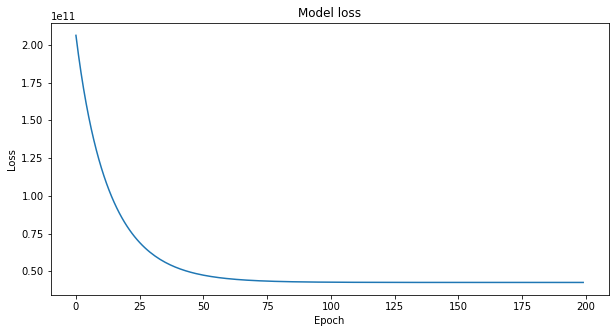

In [137]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [138]:
# Creating the coef frame for TF
coefs_df_tf = pd.DataFrame({
    'feature': features + ['intercept'],
    'coef_tf': np.append(model.get_weights()[0], model.get_weights()[1])
})

In [139]:
## Merging the two dataframes 
coefs_df_merged = coefs_df.merge(coefs_df_tf, on='feature')
coefs_df_merged['percent_diff'] = (coefs_df_merged['coef_sk'] - coefs_df_merged['coef_tf']) / coefs_df_merged['coef_sk'] * 100

In [140]:
coefs_df_merged

,feature,coef_sk,coef_tf,percent_diff
0,age,12999.031247,12999.976562,-0.007272
1,distance_from_center,-62430.341480,-62430.808594,-0.000748
2,floors,14022.123588,14021.656250,0.003333
3,sqft_living,99113.890140,99104.625000,0.009348
4,sqft_lot,9282.895480,9284.000000,-0.011898
5,sqft_above,72578.847965,72580.195312,-0.001856
6,intercept,540088.141767,539467.562500,0.114903
